In [96]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re

In [41]:
# read file 'ktotal_contratos'
df_contratos = pd.read_csv('ktotal_contratos.csv')
# clean data
### format col names 
df_contratos.columns = df_contratos.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_contratos = df_contratos[['no._carro','fecha_de_entrega_auto']]
df_contratos = df_contratos.rename(columns={'no._carro': 'stockid', 'fecha_de_entrega_auto':'date_delivery'})
### format date cols
df_contratos['date_delivery'] = pd.to_datetime(df_contratos['date_delivery'])
# examine data
print(df_contratos.shape)
df_contratos.head()

(1275, 2)


,stockid,date_delivery
0,16680,2019-11-25
1,13139,2019-11-23
2,13571,2019-11-24
3,16151,2019-12-06
4,17324,2020-01-20


In [44]:
# read file 'entregas'
df_entregas = pd.read_csv("entregas.csv")
# clean data
### format col names
df_entregas.columns = df_entregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_entregas = df_entregas[['estimate_asociado','auto', 'tipo_de_lugar_destino', 'fecha_de_entrega_agendada', 'hora', 'responsable_em_venta']]
df_entregas = df_entregas.rename(columns={'estimate_asociado': 'estimate', 'auto':'stockid', 'tipo_de_lugar_destino':'location','fecha_de_entrega_agendada':'date_delivery', 'hora':'hour'})
### format and filter by date col
df_entregas['date_delivery'] = pd.to_datetime(df_entregas['date_delivery'],  dayfirst=True)
min_date = df_contratos['date_delivery'].min()
df_entregas = df_entregas[df_entregas['date_delivery'] >= min_date]
### format hour col
def extr_hour(hr):
    return re.findall('[\d]+(?=:)', str(hr))
df_entregas['hour'] = df_entregas['hour'].apply(extr_hour)
### format estimate col
df_entregas['estimate'] = df_entregas['estimate'].str[10:]
### format stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_entregas['stockid'] = df_entregas['stockid'].apply(extr_stockid)
# examine data
print(df_entregas.shape)
df_entregas.head()

(9765, 6)


,estimate,stockid,location,date_delivery,hour,responsable_em_venta
4077,884663,15718,WH - LERMA,2019-11-02,[9],Aneyda Cervantes
4078,902755,15384,WH - LERMA,2019-11-02,[9],Ale Gonzalez
4079,888086,15690,FLORENCIA,2019-11-02,[9],Karen Garcia
4080,882772,15290,FLORENCIA,2019-11-02,[10],Aneyda Cervantes
4081,902019,15665,WH - LERMA,2019-11-02,[10],Yilda Pimentel


In [45]:
# Transform 'entregas' to include ktotal col
ktotal = np.zeros(len(df_entregas))
half_month = timedelta(days=15)
for i in range(len(df_contratos)):
    print(i)
    indcs = [ind for ind, x in enumerate(df_entregas['stockid']) 
               if int(x) == int(df_contratos['stockid'].iloc[i])]
    print(indcs)
    for j in indcs:
        if (((df_contratos['date_delivery'].iloc[i].date() -
             df_entregas['date_delivery'].iloc[j].date()) < half_month) &
            ((df_contratos['date_delivery'].iloc[i].date() -
             df_entregas['date_delivery'].iloc[j].date()) > -half_month)
           ):
            ktotal[j] = 1
df_entregas['ktotal'] = ktotal

0
[506]
1
[474]
2
[434]
3
[754]
4
[1977]
5
[1315]
6
[2098]
7
[2227]
8
[2218]
9
[2215]
10
[2198]
11
[2204]
12
[2208]
13
[10]
14
[60]
15
[2248]
16
[2245]
17
[2276]
18
[2283]
19
[2211]
20
[107]
21
[207]
22
[105]
23
[2461]
24
[221]
25
[2419]
26
[2485]
27
[485]
28
[572]
29
[210]
30
[]
31
[2506]
32
[404]
33
[2511]
34
[2494]
35
[2470]
36
[448]
37
[2553]
38
[466]
39
[3551]
40
[2563]
41
[209]
42
[2569]
43
[567]
44
[299]
45
[2606]
46
[2590]
47
[268]
48
[2602]
49
[609]
50
[2577]
51
[2602]
52
[2600]
53
[2633]
54
[2620]
55
[2144]
56
[2640]
57
[2646]
58
[2626]
59
[2637]
60
[257]
61
[2656]
62
[2614]
63
[2667]
64
[2642]
65
[2710]
66
[2712]
67
[2530]
68
[2729]
69
[2703]
70
[2689]
71
[345]
72
[2679]
73
[2705]
74
[2715]
75
[707]
76
[595]
77
[2708]
78
[2718]
79
[1886, 2736]
80
[2704]
81
[2719]
82
[2699]
83
[2675]
84
[2734]
85
[2747]
86
[2745]
87
[1929, 2746]
88
[561]
89
[2744]
90
[597]
91
[680]
92
[402]
93
[2760]
94
[2778]
95
[2763]
96
[2783]
97
[492]
98
[1070]
99
[549]
100
[3385]
101
[2816]
102
[2817]
10

[8182]
674
[8177]
675
[6350, 8332]
676
[5378, 6853, 8000]
677
[8492]
678
[7928]
679
[9331]
680
[9331]
681
[8369, 8487]
682
[8668]
683
[8534]
684
[6276, 6456, 8290]
685
[8930]
686
[8070]
687
[4700, 5675, 8185]
688
[8294]
689
[8809]
690
[]
691
[8971]
692
[8971]
693
[8125]
694
[5918, 7546]
695
[5410, 7551, 8317, 8564]
696
[5410, 7551, 8317, 8564]
697
[8444]
698
[5095, 5258, 8751]
699
[8431]
700
[8326]
701
[8169]
702
[7128]
703
[8154]
704
[8217]
705
[8437]
706
[8612]
707
[7715]
708
[3905]
709
[8257]
710
[7502]
711
[8253]
712
[8734]
713
[]
714
[8688]
715
[4976, 5375, 5789]
716
[7918, 7920, 8086]
717
[8281]
718
[8276]
719
[7942]
720
[7550, 7904]
721
[8675]
722
[8105]
723
[7905]
724
[8184]
725
[7992]
726
[4968, 8209]
727
[4653, 6331, 8632]
728
[8496]
729
[8066]
730
[8973]
731
[8973]
732
[8476]
733
[8447]
734
[8837]
735
[9587]
736
[9180]
737
[8583]
738
[8426]
739
[8479]
740
[7026, 8411]
741
[9226]
742
[8299]
743
[8739]
744
[8576]
745
[8488]
746
[8490]
747
[8618]
748
[8593]
749
[8689]
750
[7359

2020-11-11 00:00:00


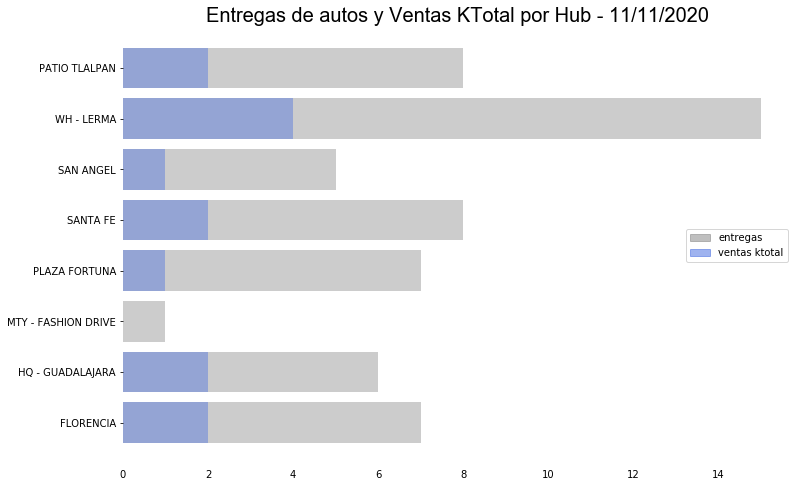

In [203]:
# Graph 1: Daily stacked bar chart
### find curr date
one_day = timedelta(days=1)
curr_day = pd.to_datetime(datetime.date(datetime.now())-one_day)
print(curr_day)
### filter data for curr day
df_curr_day = df_entregas[df_entregas['date_delivery']==curr_day]
### initialize dics
daily_entregas = {}
daily_total = {}
### find daily totals
for hub, frame in df_curr_day.groupby(['location']):
    daily_entregas[hub] = len(frame)
    daily_total[hub] = sum(frame['ktotal'])
### sort dics
sorted_entr = sorted(daily_entregas.items(), key=lambda x: x[1], reverse=True)

### set x and y values: entregas
daily_entregas.pop('CASA CLIENTE')
x_entr = daily_entregas.keys()
y_entr = daily_entregas.values()
### set x and y values: ktotal
daily_total.pop('CASA CLIENTE')
x_tot = daily_total.keys()
y_tot = daily_total.values()
### overlay two barcharts
##### barchart entregas
figure(figsize=(12,8))
bar1 = plt.barh(x_entr, y_entr, alpha=.4, color="gray")
##### barchart ktotal
bar2 = plt.barh(x_tot, y_tot, alpha=.4, color="royalblue")
# format title, axes, and legend
titlestr = ('Entregas de autos y Ventas KTotal por Hub - ' + curr_day.strftime('%d/%m/%Y'))
plt.title(titlestr, fontsize=20, fontname="Arial")
gray_patch = mpatches.Patch(color='gray', label='entregas', alpha=.5)
blue_patch = mpatches.Patch(color='royalblue', label='ventas ktotal', alpha=.5)
plt.legend(handles=[gray_patch, blue_patch], loc=7)
### remove spines and tick marks
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False)
plt.savefig('daily_report.png')  